In [2]:
#SPIN OPERATORS
import numpy as np
from matplotlib import pyplot as plt

#Pauli matrices
X=np.array([[0,1],[1,0]])
Y=np.array([[0,-1j],[1j,0]])
Z=np.array([[1,0],[0,-1]])
I=np.array([[1,0],[0,1]])

#Spin 1/2 matrices (h=1)
S_X=1/2*X
S_Y=1/2*Y
S_Z=1/2*Z
S_element=[S_X,S_Y,S_Z]

#Commutator
def comm(x,y):
    return x@y-y@x # @ is used to multiply matrices

#CLOSED SPIN CHAIN WITH L ELEMNTS (DIMENSION 2^L) optimized version 
def spin_operator(site, op, L): #site is the position of the tensor product where the operator goes. op is one of the Pauli matrices. L is the number of spins
    operators = [I] * L  # operators is a vector of L operators, initially all identities
    operators[site] = op  # We put the Pauli matrix (op) in the place we want [site]. For example, for site=2, op=S_Y ,L=4 we get operators=[I,I,S_y,I]. Now, we need to do the tensor product. 
    result=operators[0]
    for i in range(1,L):
        result=np.kron(result,operators[i]) #for i=0 we are doing operators[0]\otimes operators[1] and we save this in result. In the next step we do result \otimes operators[2] and so on. 
    return result #In our example, spin_operator(2,S_y,4)=I\otimes I\otimes S_Y\otimes Y


#SPIN MATRICES OF EACH PARTICLE IN HILBERT SPACE DIM=2^L=16
L=8 #IMPORTANT L must be even!
#From now on we work with a 8 spin chain but you only need to change this parameter to change the size of the chain
S=[] #Array, each row has to be composed of the 3 S operators of each particle in the whole hilbert space
for k in range(L):
    S_i=[] #Each row
    for l in S_element: #S_element has the 3 S operators
        S_i.append(spin_operator(k,l,L))
    S.append(S_i)
#Now S[0][1] is the S_Y operator of the 1st particle S_Y*I*I*I, or S[2][2]=I*I*S_Z*I

#print(comm(S[0][0],S[0][1])-1j*S[0][2]) #Check with the commutator that the operators are well defined

#TOTAL SPIN MATRICES (sum over all particles of each spin operator)
S_total=[]
for i in range(3): #loop over S_x S_y and S_z
    S_total.append(S[0][i]) #First we append the s_i=S_x,s_y,S_z of the first particle 
    for j in range(1,L):
        S_total[i]+=S[j][i] #We sum from the second particle (the first is already there) up to the L-th

#TOTAL S^2 OPERATOR
S2=S_total[0]@S_total[0]+S_total[1]@S_total[1]+S_total[2]@S_total[2]
    

In [3]:
#HAMILTONIAN XXX model

H_XXX=S[0][0]@S[1][0]+S[0][1]@S[1][1]+S[0][2]@S[1][2] #we initialize the hamiltonian with the first term in order to start with a matrix

for i in range(1,L): #Now we run the loop from the second term because the first one is already done
    for j in range(3): #Now we sum to perform the dot product of the i spin operator with the i+1 
        H_XXX+=S[i][j]@S[(i+1)%L][j] #IMPORTANT, how do we impose the periodic boundary condition. With (i+1)%L works. % is the modulo operation, makes the division between i+1 and L and returns the reminder. For all i+1<L (all except for the las one) the reminder is indeed i+1 so nothing changes. But for i+1=L (the one that would give problems because you are out of list) the reminder is 0 so we go back to the first spin!
        

In [31]:
#HAMILTONIAN XXZ model

Delta=-100 #anisotropy parameter

H_XXZ=-S[0][0]@S[1][0]-S[0][1]@S[1][1]-Delta*S[0][2]@S[1][2] 

for i in range(1,L): 
    for j in range(3):  
        if j<2:
            H_XXZ+=-S[i][j]@S[(i+1)%L][j] 
        else:
            H_XXZ+=-Delta*S[i][j]@S[(i+1)%L][j] 

In [26]:

# CHECKING SYMMETRIES
null_operator = np.zeros((2**L, 2**L), dtype=complex) #null operator to compare if the commutator gives 0 

def check_symm(hamiltonian, symmetry): #we perform the commutator between the hamiltonian and the symmetry operator
    commutator = comm(hamiltonian, symmetry)
    if np.allclose(commutator, null_operator, atol=1e-10):  #Allclose compare each element of both matrices and return true if they are equal. Numpy can have numerical error and even though the commutator is 0 the output can be slightly different, so we tolarate some error with atol
        print("YES, they commute!")
    else:
        print("NO, they don't commute")

# Time to check the symmetries with our hamiltonians

print("xxx Hamiltonian")
print("Symmetry [H_xxx, S^2]:", end=" ")
check_symm(H_XXX, S2)

print("Symmetry [H_xxx, S_z]:", end=" ")
check_symm(H_XXX, S_total[2])

print("Symmetry [H_xxx, S_x]:", end=" ")
check_symm(H_XXX, S_total[0])

print("Symmetry [H_xxx, S_y]:", end=" ")
check_symm(H_XXX, S_total[1])

print("\nxxz Hamiltonian")
print("Symmetry [H_xxz, S^2]:", end=" ")
check_symm(H_XXZ, S2)

print("Symmetry [H_xxz, S_z]:", end=" ")
check_symm(H_XXZ, S_total[2])

print("Symmetry [H_xxz, S_x]:", end=" ")
check_symm(H_XXZ, S_total[0])

print("Symmetry [H_xxz, S_y]:", end=" ")
check_symm(H_XXZ, S_total[1])


xxx Hamiltonian
Symmetry [H_xxx, S^2]: YES, they commute!
Symmetry [H_xxx, S_z]: YES, they commute!
Symmetry [H_xxx, S_x]: YES, they commute!
Symmetry [H_xxx, S_y]: YES, they commute!

xxz Hamiltonian
Symmetry [H_xxz, S^2]: NO, they don't commute
Symmetry [H_xxz, S_z]: YES, they commute!
Symmetry [H_xxz, S_x]: NO, they don't commute
Symmetry [H_xxz, S_y]: NO, they don't commute


In [6]:
#VQE FOR THE XXX MODEL


#INITIAL STATE, IS THE PRODUCT OF SINGLET STATES A GLOBAL SINGLET STATE?

singlet = (np.kron([1, 0], [0, 1]) - np.kron([0, 1], [1, 0])) / np.sqrt(2) #singlet of 2 spin 1/2
#total initial state

psi_0 = singlet #We start with one singlet
for _ in range(L // 2 - 1):
    psi_0 = np.kron(psi_0, singlet) #Tensor product of singlets to generate the total state

#Now we want to see if this state is an eigenstate of S^2 with s=0 i.e a global singlet state
def exp_val(A,B):
    return np.vdot(A, B @ A).real #vdot does the conjugate dot product (the usual in QM)

print("\n Expextation value with S^2 of the initial state:", exp_val(psi_0,S2))
if np.allclose(exp_val(psi_0,S2), 0):
    print(" The state is a SU(2) singlet")
else:
    print("The state is NOT a SU(2) singlet")



 Expextation value with S^2 of the initial state: 9.714451465470117e-17
 The state is a SU(2) singlet


In [7]:
#COMPARISON BETWEEN DIMENSION OF THE FULL HILBERT SPACE AND DIMENSION OF THE SINGLET SUBSPACE
import math
def dimH(L):
    return 2**L
def dimS_0(L):
    return (math.factorial(L))//(math.factorial(int(L/2+1))*math.factorial(int(L/2)))
for i in range(1,7):
    print("\nL=", 2*i, "Dim(H)=",dimH(2*i), "","Dim(S_0)=",dimS_0(2*i))




L= 2 Dim(H)= 4  Dim(S_0)= 1

L= 4 Dim(H)= 16  Dim(S_0)= 2

L= 6 Dim(H)= 64  Dim(S_0)= 5

L= 8 Dim(H)= 256  Dim(S_0)= 14

L= 10 Dim(H)= 1024  Dim(S_0)= 42

L= 12 Dim(H)= 4096  Dim(S_0)= 132


In [6]:
#EQUIVARIANT ANSATZ XXX HEISENBERG MODEL 
from scipy.linalg import expm 
from scipy.optimize import minimize


def H_odd(beta):
    Hodd=beta[0]*S[0][0]@S[1][0]+beta[1]*S[0][1]@S[1][1]+beta[2]*S[0][2]@S[1][2] # As always, first term written manually to initialize the Hamiltonian matrix.
    for i in range(1,L//2): #we sum the odd terms
        for j in range(3):       
            Hodd+=beta[j]*S[2*i][j]@S[2*i+1][j] #Notice that seems that this is the definition for H_even but python starts the index on 0. Also notice that, since L is even, H_odd goes until the last element of the chain so we don't need the the periodic boundary condition
    return Hodd

def H_even(gamma):
    Heven=gamma[0]*S[1][0]@S[2][0]+gamma[1]*S[1][1]@S[2][1]+gamma[2]*S[1][2]@S[2][2]
    for i in range(2,L//2+1): #we sum the even terms
        for j in range(3):       
            Heven+=gamma[j]*S[2*i-1][j]@S[(2*i)%L][j] #For Heven we will have the term that goes out of list so we need the periodic boundary condition. For i=L/2 (the last one) we will have S[L-1]*S[(L)%L]=S[L-1]S[0]. 
    return Heven

#Equivariant ansatz:
def equiv_ansatz(p,Beta,Gamma): #Here Beta and Gamma will only need 1 index with p components
    U1=expm(-1j*Beta[0]*H_odd([1,1,1]))@expm(-1j*Gamma[0]*H_even([1,1,1])) #The variables beta and gamma for H_odd and H_even are all 1. 
    for i in range(1,p):
        U1=U1@expm(-1j*Beta[i]*H_odd([1,1,1]))@expm(-1j*Gamma[i]*H_even([1,1,1]))
    return U1

#Cost function 
def cost_equiv(theta, p):
    Beta = theta[:p] #We will use a single vector theta with 2p elements, beta will be the first p and Gamma the other p
    Gamma = theta[p:]
    evolution_op= equiv_ansatz(p, Beta, Gamma)
    return exp_val(evolution_op@psi_0,H_XXX) #We get a function that will be optimized by minimizing the parameter theta

#Equivariant optimitzation  
energies=[]
iterations=[]

for p in range(1,6):
    theta0 = np.random.uniform(0, 2*np.pi, 2*p) #2p vector initially at random values

    result = minimize(
        cost_equiv,          # function we want to minimize
        theta0,              # variable that will minimize the function
        args=(p,),           # extra arguments for cost_equiv
        method='L-BFGS-B',   # We use a L-BFGS optimizer
        options={'gtol': 1e-4,'maxiter': 50 ,'disp': True} #Condition for the optimizer to stop. Will stop if the change on the optimizer is small enough or at some limit of iterations
    )
    print("Ground state energy=",result.fun)
    print("Number of iterations:", result.nit)
    energies.append(result.fun)
    iterations.append(result.nit)











KeyboardInterrupt: 

In [ ]:
#NON EQUIVARIANT ANSATZ XXX MODEL:

def mixing_term(alpha):
    Um=expm(-1j*alpha*S[0][1]) #First element of the mixing term 
    for i in range(1,L):
        Um=Um@expm(-1j*alpha*S[i][1])
    return Um
def non_equiv_ansatz(p,Alpha,Beta,Gamma): #Variables Beta and Gamma will need 2 indices. Alpha will just have p components (for each layer), the second will have 3 components, then Beta[0] will be a 3 component vector that will correspond to the variable in the H_odd definition. 
    U=mixing_term(Alpha[0])@expm(-1j*H_odd(Beta[0]))@expm(-1j*H_even(Gamma[0]))
    for i in range(1,p):
        U=U@mixing_term(Alpha[i])@expm(-1j*H_odd(Beta[i]))@expm(-1j*H_even(Gamma[i])) 
    return U

#Cost function 
def cost_non_equiv(theta, p): #theta has to be a 7p vector, first value of each p will be the alpha value, from 1 to 3 will be beta and from 4 to 6 gamma
    A=[]
    B=[]
    C=[]
    for i in range(p): #We split the 7p vector theta in 3 different vectors that we need for non_equiv ansatz 
        A.append(theta[7*i]) #vector with p components
        B.append([theta[7*i+1],theta[7*i+2],theta[7*i+3]]) #Vector with 3 vectors inside each of them with p components
        C.append([theta[7*i+4],theta[7*i+5],theta[7*i+6]]) #Same
    evolution_op= non_equiv_ansatz(p,A,B,C)
    return exp_val(evolution_op@psi_0,H_XXX) #We get a function that will be optimized by minimizing the parameter theta

#Non-equivariant optimitzation  
non_equiv_energies=[]
non_equiv_iterations=[]

for p in range(1,6):
    non_equiv_theta0 = np.random.uniform(0, 2*np.pi, 7*p) #7p vector initially at random values

    non_equiv_result = minimize(
        cost_non_equiv,          # function we want to minimize
        non_equiv_theta0,              # variable that will minimize the function
        args=(p,),           # extra arguments for cost_equiv
        method='L-BFGS-B',   # We use a L-BFGS optimizer
        options={'gtol': 1e-4,'maxiter': 50 ,'disp': True} #Condition for the optimizer to stop. Will stop if the change on the optimizer is small enough or at some limit of iterations
    )
    print("Ground state energy=",non_equiv_result.fun)
    print("Number of iterations:", non_equiv_result.nit)
    non_equiv_energies.append(non_equiv_result.fun)
    non_equiv_iterations.append(non_equiv_result.nit)

Ground state energy= -2.424181235474839
Number of iterations: 26
Ground state energy= -1.257753465404148
Number of iterations: 50
Ground state energy= -2.752959175207706
Number of iterations: 50
Ground state energy= -2.738498658278174
Number of iterations: 50
Ground state energy= -0.41970247394629445
Number of iterations: 50


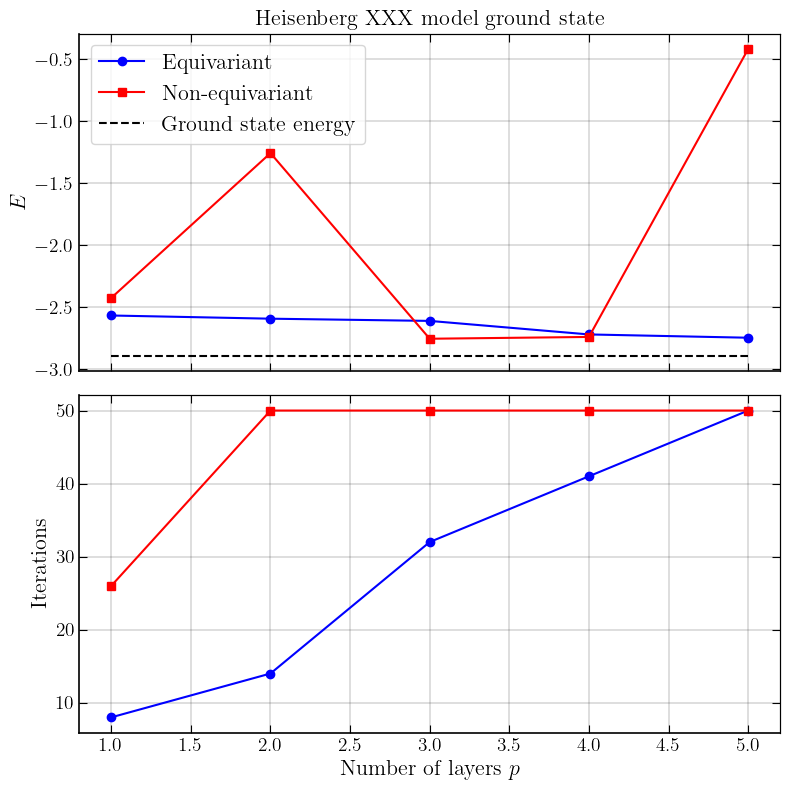

In [ ]:
#PLOT EQUIVARIANT ANSATZ XXX MODEL

plt.rcParams.update({
    "figure.figsize": (8, 8),  
    "grid.color": "0.1", 
    "grid.linestyle": "-",  
    "grid.linewidth": 0.2,  
    "text.usetex": True,  
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{amsmath}",
})



layers=[1,2,3,4,5]

#Exact value 
GS=np.min(np.linalg.eigvalsh(H_XXX))
GSE=[]
for i in range(len(layers)):
    GSE.append(GS)


fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)  # Two subplots with same x axis

#First figure
ax1.set_title("Heisenberg XXX model ground state",fontsize=16)
ax1.plot(layers,energies, "b-o", label="Equivariant")
ax1.plot(layers,non_equiv_energies,"r-s", label="Non-equivariant")
ax1.plot(layers,GSE,color="black",linestyle='--', label="Ground state energy")

ax1.set_ylabel("$E$",fontsize=16)
ax1.legend(loc='best', facecolor='w', fontsize=16)
ax1.grid(True)  

ax1.tick_params(axis='both', labelsize=14)  

ax1.spines['bottom'].set_linewidth(1.2)
ax1.spines['left'].set_linewidth(1.2)
ax1.spines['top'].set_visible(1.2)
ax1.spines['right'].set_visible(1.2)

ax1.tick_params(axis='x', direction='in', length=6, color='black')
ax1.tick_params(axis='y', direction='in', length=6, color='black')

secax = ax1.secondary_xaxis('top')
secay = ax1.secondary_yaxis('right')

secax.tick_params(axis='x', direction='in', length=6, color='black')
secay.tick_params(axis='y', direction='in', length=6, color='black')

secay.set_yticklabels([])
secax.set_xticklabels([])


#Second figure
ax2.plot(layers,iterations, "b-o")
ax2.plot(layers,non_equiv_iterations,"r-s")



ax2.set_xlabel("Number of layers $p$",fontsize=16)
ax2.set_ylabel("Iterations",fontsize=16)
ax2.grid(True)  


ax2.tick_params(axis='both', labelsize=14)  


ax2.spines['bottom'].set_linewidth(1.2)
ax2.spines['left'].set_linewidth(1.2)
ax2.spines['top'].set_visible(1.2)
ax2.spines['right'].set_visible(1.2)


ax2.tick_params(axis='x', direction='in', length=6, color='black')
ax2.tick_params(axis='y', direction='in', length=6, color='black')

secax = ax2.secondary_xaxis('top')
secay = ax2.secondary_yaxis('right')

secax.tick_params(axis='x', direction='in', length=6, color='black')
secay.tick_params(axis='y', direction='in', length=6, color='black')

secay.set_yticklabels([])
secax.set_xticklabels([])

plt.tight_layout()
plt.show()




In [27]:
#VQE FOR THE XXZ MODEL


#INITIAL STATE superposition of neel states
up=[1,0]
down=[0,1]

#neel starting with up
neel_up=up #First element is an up spin
for i in range(1,L): 
    neel_up=np.kron(neel_up, up if i % 2 == 0 else down)#This way we alternate between up and down

#neel starting with down
neel_down=down
for i in range(1,L): 
    neel_down=np.kron(neel_down, down if i % 2 == 0 else up)#This way we alternate the opposite way 

phi_0=(neel_up+neel_down)/np.sqrt(2)


#This state belongs to the m=0 sector? If so, the expectation value with S^z should be 0
print("\n Expextation value with S^z of the initial state:", exp_val(phi_0,S_total[2]))
if np.allclose(exp_val(phi_0,S_total[2]), 0):
    print(" The state is belongs to the m=0 sector")
else:
    print("The state does NOT belong to the m=0 sector")





 Expextation value with S^z of the initial state: 0.0
 The state is belongs to the m=0 sector


In [32]:
#EQUIVARIANT ANSATZ XXZ HEISENBERG MODEL 

from scipy.linalg import expm 
from scipy.optimize import minimize

#we are going to define the hamiltonians again because were defined in the equivariant ansatz for the XXX model and we are not executing this part of the code again. 
#Since we need to define them again we are going to use the parameters we need for the xxz model

def H_odd_xxz(beta_xy, beta_z):
    Hodd=beta_xy*S[0][0]@S[1][0]+beta_xy*S[0][1]@S[1][1]+beta_z*S[0][2]@S[1][2] # As always, first term written manually to initialize the Hamiltonian matrix.
    for i in range(1,L//2): #we sum the odd terms
        Hodd+=beta_xy*S[2*i][0]@S[2*i+1][0]+beta_xy*S[2*i][1]@S[2*i+1][1]+beta_z*S[2*i][2]@S[2*i+1][2]
    return Hodd

def H_even_xxz(gamma_xy,gamma_z):
    Heven=gamma_xy*S[1][0]@S[2][0]+gamma_xy*S[1][1]@S[2][1]+gamma_z*S[1][2]@S[2][2]
    for i in range(2,L//2+1): #we sum the even terms
        Heven=gamma_xy*S[2*i-1][0]@S[(2*i)%L][0]+gamma_xy*S[2*i-1][1]@S[(2*i)%L][1]+gamma_z*S[2*i-1][2]@S[(2*i)%L][2]
    return Heven

#Equivariant ansatz
def xxz_equiv_ansatz(p,Beta_xy,Beta_z,Gamma_xy,Gamma_z): 
    U1=expm(-1j*H_odd_xxz(Beta_xy[0],Beta_z[0]))@expm(-1j*H_even_xxz(Gamma_xy[0],Gamma_z[0]))  
    for i in range(1,p):
        U1=U1@expm(-1j*H_odd_xxz(Beta_xy[i],Beta_z[i]))@expm(-1j*H_even_xxz(Gamma_xy[i],Gamma_z[i]))  
    return U1

#Cost function 
def xxz_cost_equiv(theta, p):
    a = theta[0*p : 1*p]
    b = theta[1*p : 2*p]
    c = theta[2*p : 3*p]
    d = theta[3*p : 4*p]
    xxz_evolution_op= xxz_equiv_ansatz(p, a,b,c,d)
    return exp_val(xxz_evolution_op@psi_0,H_XXZ) #We get a function that will be optimized by minimizing the parameter theta

#Optimitzation
energies=[]
iterations=[]

p=10
theta0 = np.random.uniform(-2*np.pi, 2*np.pi, 4*p) #4p vector initially at random values
a = theta0[0*p : 1*p]
b = theta0[1*p : 2*p]
c = theta0[2*p : 3*p]
d = theta0[3*p : 4*p]
psi_f = xxz_equiv_ansatz(p, a, b, c, d) @ psi_0
overlap = np.abs(np.vdot(psi_0, psi_f))
print("Overlap:", overlap)  # Si es ~1, no hace nada


"""
for p in range(1,2):
    theta0 = np.random.uniform(-2*np.pi, 2*np.pi, 4*p) #4p vector initially at random values

    result = minimize(
        xxz_cost_equiv,          # function we want to minimize
        theta0,              # variable that will minimize the function
        args=(p,),           # extra arguments for cost_equiv
        method='L-BFGS-B',   # We use a L-BFGS optimizer
        options={'gtol': 1e-4,'maxiter': 50 ,'disp': True} #Condition for the optimizer to stop. Will stop if the change on the optimizer is small enough or at some limit of iterations
    )
    print("Ground state energy=",result.fun)
    print("Number of iterations:", result.nit)
    energies.append(result.fun)
    iterations.append(result.nit)"""

Overlap: 0.9999999999999971


'\nfor p in range(1,2):\n    theta0 = np.random.uniform(-2*np.pi, 2*np.pi, 4*p) #4p vector initially at random values\n\n    result = minimize(\n        xxz_cost_equiv,          # function we want to minimize\n        theta0,              # variable that will minimize the function\n        args=(p,),           # extra arguments for cost_equiv\n        method=\'L-BFGS-B\',   # We use a L-BFGS optimizer\n        options={\'gtol\': 1e-4,\'maxiter\': 50 ,\'disp\': True} #Condition for the optimizer to stop. Will stop if the change on the optimizer is small enough or at some limit of iterations\n    )\n    print("Ground state energy=",result.fun)\n    print("Number of iterations:", result.nit)\n    energies.append(result.fun)\n    iterations.append(result.nit)'

In [23]:
GS=np.min(np.linalg.eigvalsh(H_XXZ))
print(GS)




-7.823122584647934
